In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import json
from PIL import Image
import pickle
import time

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Import embeddings

In [3]:
# Dicts with number of tiles for each slide
tiles_num_dict_path = './data/num_tiles_dict_comb_tr.json'
with open(tiles_num_dict_path) as json_file:
    num_tiles_dict_comb_tr = json.load(json_file)
    
tiles_num_dict_path = './data/num_tiles_dict_comb_val.json'
with open(tiles_num_dict_path) as json_file:
    num_tiles_dict_comb_val = json.load(json_file)

tiles_num_dict_path = './data/num_tiles_dict_comb_ts.json'
with open(tiles_num_dict_path) as json_file:
    num_tiles_dict_comb_ts = json.load(json_file)

In [4]:
 def get_tile(index, dataset='comb_tr'):
    tiles_path='../WSI/tiles/'
    curr_tiles_sum = 0
    
    if dataset=='comb_val':
        num_tiles_dict = num_tiles_dict_comb_val
    elif dataset=='comb_ts':
        num_tiles_dict = num_tiles_dict_comb_ts
    else:
        num_tiles_dict = num_tiles_dict_comb_tr

    for slide_name in num_tiles_dict:
        if index < curr_tiles_sum + num_tiles_dict[slide_name]:
            selected_slide_name = slide_name
            break
        curr_tiles_sum += num_tiles_dict[slide_name]

    tile_idx = index - curr_tiles_sum

    tile_path = os.path.join(tiles_path, selected_slide_name, str(tile_idx) + '.jpg')

    img = Image.open(tile_path)


    return img, selected_slide_name

In [5]:
epoch = 20
save_model_path = './ae_models/comb_ae/'


embed_path_comb_tr = os.path.join(save_model_path, 'z_ae_test_epoch{}.npy'.format(epoch))
embed_tiles_comb_tr = np.load(embed_path_comb_tr)

# K-means

In [7]:
n_clusters_arr = [32, 64, 128, 256]
#n_clusters_arr = [128, 256]

In [8]:
for n_clusters in n_clusters_arr:
    start_time = time.time()
    
    kmeans = KMeans(n_clusters=n_clusters).fit(embed_tiles_comb_tr)
    kmeans_pth = os.path.join("./clustering", "comb_ae")
    if not os.path.exists(kmeans_pth):
        os.makedirs(kmeans_pth)
    pickle.dump(kmeans, open(kmeans_pth+ "/kmeans{}".format(n_clusters), 'wb'))
    
    end_time = time.time()
    print('kmeans{}: {:.8f}'.format(n_clusters, end_time - start_time))

kmeans32: 701.31296849
kmeans64: 1400.84013176
kmeans128: 2791.35262060
kmeans256: 5434.65597558


# Visualize

In [11]:
X_embedded_pca = PCA(n_components=2).fit_transform(embed_tiles_comb_tr)
x_component_pca = X_embedded_pca[:,0]
y_component_pca = X_embedded_pca[:,1]

In [12]:
for n_clusters in n_clusters_arr:
    kmeans_pth = os.path.join("./clustering", "comb_ae", "kmeans{}".format(n_clusters))
    kmeans = pickle.load(open(kmeans_pth, 'rb'))

    fig = px.scatter(X_embedded_pca, x=x_component_pca, y=y_component_pca, size_max=60,
                     color=kmeans.labels_, title="Kmeans-{}".format(n_clusters))
    fig.update_layout(height=800)
    fig.write_image("images/kmeans{}.png".format(n_clusters))
    #fig.show()

KeyboardInterrupt: 

# Show tiles

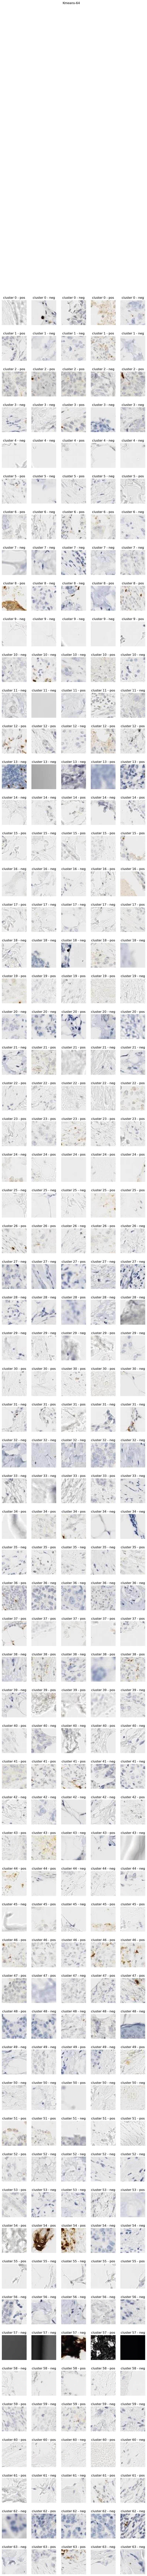

In [13]:
num_tiles_per_cluster = 5
n_clusters_arr = [64]

for n_clusters in n_clusters_arr:
    
    kmeans_pth = os.path.join("./clustering", "comb_ae", "kmeans{}".format(n_clusters))
    kmeans = pickle.load(open(kmeans_pth, 'rb'))
    
    clusters_indexes_arr = []
    fig, axs = plt.subplots(n_clusters, num_tiles_per_cluster, figsize=(10,2.5*n_clusters))

    for c in range(n_clusters):
        cluster_index = [i for i, x in enumerate(kmeans.labels_) if x == c]
        random_indexes = np.random.choice(cluster_index, size=num_tiles_per_cluster, replace=False)
        
        for j, rand_idx in enumerate(random_indexes):
            tile, slide_name = get_tile(rand_idx)
            axs[c][j].imshow(tile)
            axs[c][j].axis('off')
            if results_dict.get(slide_name) == None:
                if ext_results_dict[slide_name] == 1:
                    positivity = 'pos'
                else:
                    positivity = 'neg'
            elif results_dict[slide_name] == 1:
                positivity = 'pos'
            else:
                positivity = 'neg'
            #axs[c][j].set_title('cluster '+str(c)+" - "+slide_name + ' ' + positivity)
            axs[c][j].set_title('cluster '+str(c)+' - ' + positivity)
    fig.suptitle('Kmeans-{}'.format(n_clusters))
    plt.show()

Count samples percentage for each cluster

In [ ]:
n_clusters = 64

kmeans_pth = os.path.join("./clustering", "comb_ae", "kmeans{}".format(n_clusters))
kmeans = pickle.load(open(kmeans_pth, 'rb'))
labels = kmeans.labels_

unique, counts = np.unique(labels, return_counts=True)
dict(zip(unique, np.divide(counts*100, len(labels))))

# Cluster labels subdivision by slide

In [10]:
def subdivide_clusters_by_slide(n_clusters, labels, dataset='comb_tr'):
    # Labels are still ordered by slide, ie the first 25000 tiles are from the first slide, tile 25001
    # to 70000 is from the second slide and so on
    
    if dataset=='comb_val':
        num_tiles_dict = num_tiles_dict_comb_val
    elif dataset=='comb_ts':
        num_tiles_dict = num_tiles_dict_comb_ts
    else:
        num_tiles_dict = num_tiles_dict_comb_tr

    slide_cluster_pth = "./clustering/comb_ae/slide_clusters/kmeans{}".format(n_clusters)
    if not os.path.exists(slide_cluster_pth):
        os.makedirs(slide_cluster_pth)

    start = 0
    end = 0
    for slide_name in num_tiles_dict:
        slide_num_tiles = num_tiles_dict[slide_name]
        end += slide_num_tiles
        slide_labels = labels[start:end]
        start += slide_num_tiles
        np.save(os.path.join(slide_cluster_pth, slide_name+".npy"), slide_labels)

In [15]:
for n_clusters in n_clusters_arr:
    kmeans_pth = os.path.join("./clustering", "comb_ae", "kmeans{}".format(n_clusters))
    kmeans = pickle.load(open(kmeans_pth, 'rb'))
    labels = kmeans.labels_
        
    subdivide_clusters_by_slide(n_clusters, labels)

# Combined Validation Set

Predict tile clustering for internal test set

In [16]:
epoch = 20
save_model_path = './ae_models/comb_ae/'


embed_path_comb_val = os.path.join(save_model_path, 'z_ae_internal_test_epoch{}.npy'.format(epoch))
embed_tiles_comb_val = np.load(embed_path_comb_val)

In [17]:
n_clusters_arr = [32, 64, 128, 256]
#n_clusters_arr = [32, 64]

In [18]:
labels_arr = []


for n_clusters in n_clusters_arr:
    print('Doing {} clusters'.format(n_clusters))
    
    kmeans_pth = os.path.join("./clustering", "ae", "kmeans{}".format(n_clusters))
    kmeans = pickle.load(open(kmeans_pth, 'rb'))

    labels = kmeans.predict(embed_tiles_comb_val)
    labels_arr.append(labels)
    
    subdivide_clusters_by_slide(n_clusters, labels, dataset='comb_val')
    print('Finished {} clusters'.format(n_clusters))

Doing 32 clusters
Finished 32 clusters
Doing 64 clusters
Finished 64 clusters
Doing 128 clusters
Finished 128 clusters
Doing 256 clusters
Finished 256 clusters


Visualize validation clustered tiles

In [ ]:
num_tiles_per_cluster = 5
n_clusters_arr = [64]

for n_clusters in n_clusters_arr:
    
    kmeans_pth = os.path.join("./clustering", "comb_ae", "kmeans{}".format(n_clusters))
    kmeans = pickle.load(open(kmeans_pth, 'rb'))
    
    clusters_indexes_arr = []
    fig, axs = plt.subplots(n_clusters, num_tiles_per_cluster, figsize=(10,2.5*n_clusters))

    for c in range(n_clusters):
        cluster_index = [i for i, x in enumerate(labels_arr[1]) if x == c]
        
        if len(cluster_index) >= num_tiles_per_cluster: 
            random_indexes = np.random.choice(cluster_index, size=num_tiles_per_cluster, replace=False)

            for j, rand_idx in enumerate(random_indexes):
                tile, slide_name = get_tile(rand_idx)
                axs[c][j].imshow(tile)
                axs[c][j].axis('off')
                if results_dict.get(slide_name) == None:
                    if ext_results_dict[slide_name] == 1:
                        positivity = 'pos'
                    else:
                        positivity = 'neg'
                elif results_dict[slide_name] == 1:
                    positivity = 'pos'
                else:
                    positivity = 'neg'
                #axs[c][j].set_title('cluster '+str(c)+" - "+slide_name + ' ' + positivity)
                axs[c][j].set_title('cluster '+str(c)+' - ' + positivity)
    fig.suptitle('Kmeans-{}'.format(n_clusters))
    plt.show()

# Combined Test Set

In [6]:
epoch = 20
save_model_path = './ae_models/comb_ae/'


embed_path_comb_ts = os.path.join(save_model_path, 'z_ae_ext_test_epoch{}.npy'.format(epoch))
embed_tiles_comb_ts = np.load(embed_path_comb_ts)

In [7]:
n_clusters_arr = [32, 64, 128, 256]
#n_clusters_arr = [32, 64]

In [11]:
labels_arr = []

for n_clusters in n_clusters_arr:
    print('Doing {} clusters'.format(n_clusters))
    
    kmeans_pth = os.path.join("./clustering", "comb_ae", "kmeans{}".format(n_clusters))
    kmeans = pickle.load(open(kmeans_pth, 'rb'))

    labels = kmeans.predict(embed_tiles_comb_ts)
    labels_arr.append(labels)
    
    subdivide_clusters_by_slide(n_clusters, labels, dataset='comb_ts')
    print('Finished {} clusters'.format(n_clusters))

Doing 32 clusters
Finished 32 clusters
Doing 64 clusters
Finished 64 clusters
Doing 128 clusters
Finished 128 clusters
Doing 256 clusters
Finished 256 clusters


Show tiles clusters ext

In [12]:
num_tiles_per_cluster = 5
n_clusters_arr = [64]

for n_clusters in n_clusters_arr:
    
    kmeans_pth = os.path.join("./clustering", "comb_ae", "kmeans{}".format(n_clusters))
    kmeans = pickle.load(open(kmeans_pth, 'rb'))
    
    clusters_indexes_arr = []
    fig, axs = plt.subplots(n_clusters, num_tiles_per_cluster, figsize=(10,2.5*n_clusters))

    for c in range(n_clusters):
        cluster_index = [i for i, x in enumerate(labels_arr[1]) if x == c]
        random_indexes = np.random.choice(cluster_index, size=num_tiles_per_cluster, replace=False)
        
        for j, rand_idx in enumerate(random_indexes):
            tile, slide_name = get_tile(rand_idx)
            axs[c][j].imshow(tile)
            axs[c][j].axis('off')
            if results_dict.get(slide_name) == None:
                if ext_results_dict[slide_name] == 1:
                    positivity = 'pos'
                else:
                    positivity = 'neg'
            elif results_dict[slide_name] == 1:
                positivity = 'pos'
            else:
                positivity = 'neg'
            #axs[c][j].set_title('cluster '+str(c)+" - "+slide_name + ' ' + positivity)
            axs[c][j].set_title('cluster '+str(c)+' - ' + positivity)
    fig.suptitle('Kmeans-{}'.format(n_clusters))
    plt.show()

NameError: name 'results_dict' is not defined

Count samples percentage for each cluster

In [13]:
unique, counts = np.unique(labels_arr[1], return_counts=True)
dict(zip(unique, np.divide(counts*100, len(labels_arr[1]))))

{0: 0.6978789038422776,
 1: 2.116714331201818,
 2: 5.782842520076069,
 3: 1.224574451614411,
 4: 0.6192981482401124,
 5: 1.7533148517628088,
 6: 1.5929400011100627,
 7: 1.2321696175833934,
 8: 1.263426646763437,
 9: 1.2926388235672157,
 10: 2.893466112414299,
 11: 2.2931558790966426,
 12: 2.1383313420366146,
 13: 0.9806527753028572,
 14: 0.6382860631625686,
 15: 0.5304931307566246,
 16: 0.597681137405316,
 17: 1.0939960213015194,
 18: 0.855040415046608,
 19: 1.8345247032773142,
 20: 1.08201902881197,
 21: 1.6072539677439144,
 22: 1.9852595355848133,
 23: 1.9294642778895954,
 24: 0.8392658395725674,
 25: 0.5351670790452292,
 26: 1.9642267682860923,
 27: 3.1359271798856634,
 28: 0.9680915392772323,
 29: 0.9967194725449356,
 30: 1.5421108134714874,
 31: 0.43496931260826766,
 32: 4.037999199586356,
 33: 3.179745445091332,
 34: 1.8646132453852065,
 35: 1.6975195940675911,
 36: 5.16967892896475,
 37: 0.5801538313230487,
 38: 1.3528159077830002,
 39: 0.6496788121160425,
 40: 0.750168700321041

In [1]:
unique, counts = np.unique(labels_arr[3], return_counts=True)
dict(zip(unique, counts))

NameError: name 'np' is not defined